In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
import random
import sys
from copy import deepcopy
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from ex_biology import p
sys.path.append('preprocessing')
import data
import neural_networks

# adaptive-wavelets modules
sys.path.append('../..')
from src import adaptive_wavelets
from src.dsets.biology import dset
from src.visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

sys.path.append('../../lib/trim')
from trim import TrimModel

In [2]:
# parameters for initialization
p.wave = 'db5'
p.J = 4
p.mode = 'zero'
p.init_factor = 1
p.noise_factor = 0    
p.const_factor = 0
p.num_epochs = 200
p.lamL1wave = 0.0000
p.lamL1attr = 0.2

In [3]:
# load data and model
train_loader, test_loader = dset.get_dataloader(p.data_path, 
                                                batch_size=p.batch_size,
                                                is_continuous=p.is_continuous)   

model = dset.load_pretrained_model(p.model_path, device=device)  

# prepare model
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)  

wt = adaptive_wavelets.DWT1d(wave=p.wave, mode=p.mode, J=p.J, 
                             init_factor=p.init_factor, 
                             noise_factor=p.noise_factor,
                             const_factor=p.const_factor).to(device)
wt.train()

# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=p.lr)
loss_f = adaptive_wavelets.get_loss_f(lamlSum=p.lamlSum, lamhSum=p.lamhSum, lamL2norm=p.lamL2norm, 
                                      lamCMF=p.lamCMF, lamConv=p.lamConv, lamL1wave=p.lamL1wave, lamL1attr=p.lamL1attr)

model = model.to(device)
wt_inverse = wt.inverse 
mt = TrimModel(model, wt_inverse, use_residuals=True) 
attributer = adaptive_wavelets.Attributer(mt, attr_methods=p.attr_methods, device=device)
target = p.target
n_print = 5

In [4]:
# store training losses
train_losses = []

for epoch in range(p.num_epochs):
    epoch_loss = 0.
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        
        # zero grad
        optimizer.zero_grad()
        
        # transform
        data_t = wt(data)

        # reconstruction
        recon_data = wt_inverse(data_t) 
        
        # TRIM score
        with torch.backends.cudnn.flags(enabled=False):
            attributions = attributer(data_t, target=p.target, additional_forward_args=deepcopy(data)) if loss_f.lamL1attr > 0 else None        
        
        # loss
        loss = loss_f(wt, data, recon_data, data_t, attributions) 
        
        # backward
        loss.backward()
        
        # update step
        optimizer.step()          
        
        iter_loss = loss.item()   
        epoch_loss += iter_loss
        
        if epoch % n_print == 0:      
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), iter_loss), end='')              

    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    
    if epoch % n_print == 0:
        print('\n====> Epoch: {} Average train loss: {:.4f}'.format(epoch, mean_epoch_loss)) 
        
    train_losses.append(mean_epoch_loss)
    

Train Epoch: 0 [1044/2936 (97%)]	Loss: 0.094283
====> Epoch: 0 Average train loss: 0.0924
Train Epoch: 5 [1044/2936 (97%)]	Loss: 0.074070
====> Epoch: 5 Average train loss: 0.0862
Train Epoch: 10 [1044/2936 (97%)]	Loss: 0.079785
====> Epoch: 10 Average train loss: 0.0859
Train Epoch: 15 [1044/2936 (97%)]	Loss: 0.080169
====> Epoch: 15 Average train loss: 0.0855
Train Epoch: 20 [1044/2936 (97%)]	Loss: 0.092777
====> Epoch: 20 Average train loss: 0.0853
Train Epoch: 25 [1044/2936 (97%)]	Loss: 0.084967
====> Epoch: 25 Average train loss: 0.0845
Train Epoch: 30 [1044/2936 (97%)]	Loss: 0.078777
====> Epoch: 30 Average train loss: 0.0838
Train Epoch: 35 [1044/2936 (97%)]	Loss: 0.085893
====> Epoch: 35 Average train loss: 0.0833
Train Epoch: 40 [1044/2936 (97%)]	Loss: 0.084427
====> Epoch: 40 Average train loss: 0.0827
Train Epoch: 45 [1044/2936 (97%)]	Loss: 0.091669
====> Epoch: 45 Average train loss: 0.0823
Train Epoch: 50 [1044/2936 (97%)]	Loss: 0.071914
====> Epoch: 50 Average train loss:

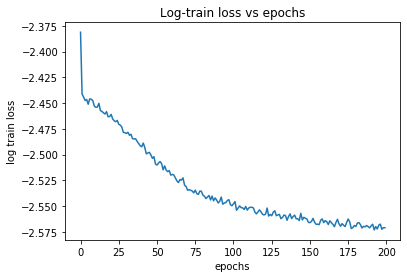

In [5]:
plt.plot(np.log(train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

Reconstruction error=0.00057


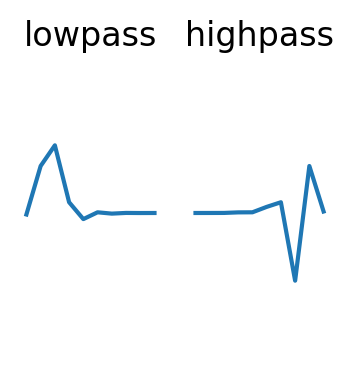

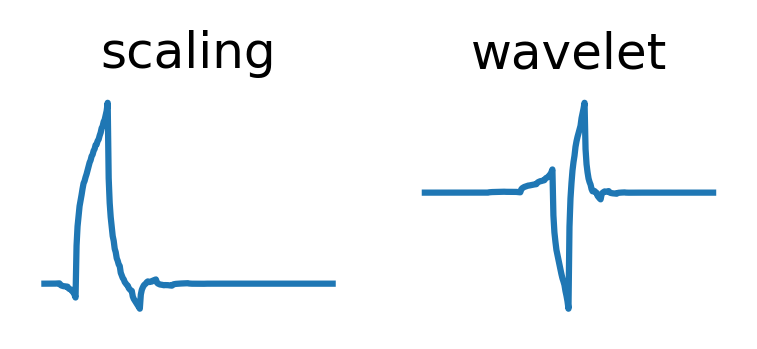

In [6]:
data = iter(test_loader).next()[0].to(device)
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 2d wavelet filters
filt = adaptive_wavelets.get_1dfilts(wt)
phi, psi, x = adaptive_wavelets.get_wavefun(wt)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))